##### This Notebook has been adapted from a course gave by Robert Gower at AMMI

# First order methods on regression models

    Lab 1 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT


- **Each** student must send their jupyter notebook solutions **before the 5th of July at 23:59**  to **tngoupeyou@aimsammi.org**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "aissatou"
ln1 = "gueye"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_gueye_aissatou.ipynb


In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

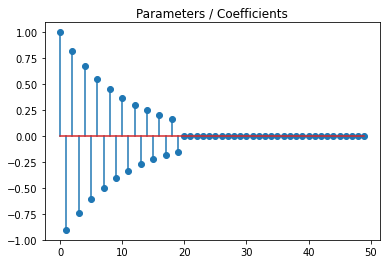

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [ ]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x with strength t"""   
    return np.sign(x)*np.maximum(np.abs(x)-s,0)

def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*norm((x), ord=1)

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    return x/(1.+s*t)

def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return (s/2.) * (np.linalg.norm((x), ord=2) ** 2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plo

(-2.0, 2.0)

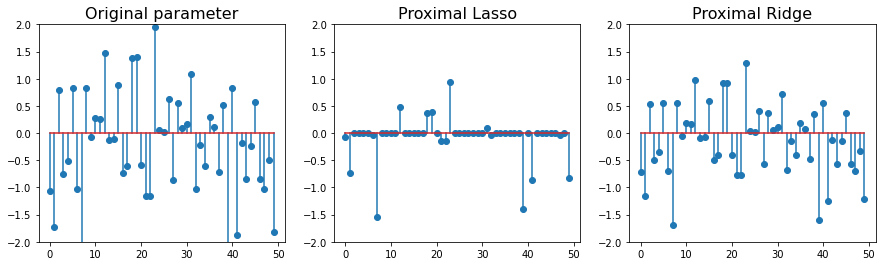

In [ ]:
x = randn(50)

l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])


## Question

- Comment what you observe (1 or 2 sentences).

### Comments
 
With the lasso regularization, the coefficients with absolute value under $t\cdot s$ vanish since the proximal operator is such that $ \text{sign}(x)(|x|-t\cdot s)_{+} $, the non-zero coefficients decrease by the constant scalar $t\cdot s$, we can see that the L1 norm induces sparsity.

With a ridge regularization, the value of the coefficients is smaller but still positive, more precisely, the magnitude of the coefficients is shrinked by the same factor $\frac{1}{1 + t\cdot s}$.


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [ ]:
A,b = simu_linreg(coefs)
def loss_linreg(x, A=A,b=b):
    """Least-squares loss"""
    return 1/(2*len(b)) * np.linalg.norm(b-np.dot(A,x), ord=2)**2

def grad_linreg(x,A=A,b=b):
    """Least-squares gradient"""
    return -1/(len(b)) * np.dot(A.T, b - np.dot(A,x))

def loss_logreg(x, A=A, b=b):
    """Logistic loss"""
    return 1/(len(b)) * np.log(1 + np.exp(-np.multiply(b, A.dot(x)))).sum()
    
def grad_logreg(x, A=A, b=b):
    """Logistic gradient"""
    return sum((-b[i]*np.transpose(A[i, :]) * np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) / (len(b) * (1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x)))) for i in range(len(b)))

In [ ]:
from scipy.optimize import check_grad
A,b = simu_linreg(coefs)
print("Check grad_linreg:", check_grad(loss_linreg, grad_linreg, x0=randn(A.shape[1])))
A,b = simu_logreg(coefs)
print("Check grad_logreg:", check_grad(loss_logreg, grad_logreg, x0=randn(A.shape[1])))

Check grad_linreg: 2.175833972604262e-06
Check grad_logreg: 1.320782583949301e-07


The above "grad" functions seem to be correct : the check_grad output is small.  

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` below that implements the 
  ISTA (Proximal Gradient Descent) algorithm</li>
    <li> BONUS QUESTION:  Implement FISTA (Accelerated Proximal 
  Gradient Descent) algorithm as described at the bottom
    </ul>
</div>

In [ ]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return 1/(len(b)) * np.linalg.norm(np.dot(A.T,A), ord=2)

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return 1/(4. * len(b)) * np.linalg.norm(A, ord=2)**2

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
        x_true=coefs, verbose=True):
  """Proximal gradient descent algorithm"""
  x = x0.copy()
  x_new = x0.copy()
  n_samples, n_features = A.shape

  # estimation error history
  errors = []
  # objective history
  objectives = []
  # Current estimation error
  err = norm(x - x_true) / norm(x_true)
  errors.append(err)
  # Current objective
  obj = f(x) + g(x, s)
  objectives.append(obj)
  if verbose:
      print("Lauching ISTA solver...")
      print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
  for k in range(n_iter + 1):

      x = prox_g(x - step*grad_f(x), s, step)
  
      obj = f(x) + g(x, s)
      err = norm(x - x_true) / norm(x_true)
      errors.append(err)
      objectives.append(obj)
      if k % 10 == 0 and verbose:
          print(' | '.join([("%d" % k).rjust(8), 
                            ("%.2e" % obj).rjust(8), 
                            ("%.2e" % err).rjust(8)]))
  return x, objectives, errors

Try and implement the FISTA algorithm (detailed in maths below)

FISTA Algorithm:
$$\begin{array}{l}
\mbox{Set } w^1=0=z^1, \beta^1 =1\\
\mbox{for }t=1,2,3, \ldots, T \quad  \\
\qquad \displaystyle w^{t+1} = \mbox{prox}_{\left. \lambda R \right/ \mathcal{L}}\left( z^t - \frac{1}{\mathcal{L}} \nabla L(z^t)\right) \\
\qquad \displaystyle \beta^{t+1} = \frac{1+\sqrt{1+4(\beta^t)^2}}{2}\\
\qquad \displaystyle  z^{t+1} = w^{t+1} + \frac{\beta^t -1}{\beta^{t+1}} (w^{t+1} -w^{t})\\
\mbox{Output } w^{T+1}
\end{array}$$

In [ ]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter + 1):
    
        x_new = prox_g(z - step*grad_f(z),s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        x, z, t = x_new, z_new, t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2
s

0.01

In [ ]:
# test:
norm = np.linalg.norm 
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)

F= fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0., n_iter=50,x_true=coefs, verbose=True)
I= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0., n_iter=50,x_true=coefs, verbose=True)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.33e+00 | 8.81e-01
      10 | 4.86e-01 | 1.18e-01
      20 | 4.85e-01 | 1.27e-01
      30 | 4.85e-01 | 1.20e-01
      40 | 4.85e-01 | 1.23e-01
      50 | 4.85e-01 | 1.22e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.33e+00 | 8.81e-01
      10 | 5.77e-01 | 2.86e-01
      20 | 4.97e-01 | 1.21e-01
      30 | 4.86e-01 | 1.06e-01
      40 | 4.85e-01 | 1.14e-01
      50 | 4.85e-01 | 1.19e-01


**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using FISTA with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [ ]:
# Minimum and minimizer of the linear regression with ridge penalization
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
X, obj, err = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
minimum = obj[-1]
minimizer = X[-1]
print("minimum:", minimum)
print("minimizer:", minimizer)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.32e+00 | 8.75e-01
      10 | 5.14e-01 | 1.13e-01
      20 | 5.14e-01 | 1.11e-01
      30 | 5.14e-01 | 1.10e-01
      40 | 5.14e-01 | 1.10e-01
      50 | 5.14e-01 | 1.10e-01
      60 | 5.14e-01 | 1.10e-01
      70 | 5.14e-01 | 1.10e-01
      80 | 5.14e-01 | 1.10e-01
      90 | 5.14e-01 | 1.10e-01
     100 | 5.14e-01 | 1.10e-01
     110 | 5.14e-01 | 1.10e-01
     120 | 5.14e-01 | 1.10e-01
     130 | 5.14e-01 | 1.10e-01
     140 | 5.14e-01 | 1.10e-01
     150 | 5.14e-01 | 1.10e-01
     160 | 5.14e-01 | 1.10e-01
     170 | 5.14e-01 | 1.10e-01
     180 | 5.14e-01 | 1.10e-01
     190 | 5.14e-01 | 1.10e-01
     200 | 5.14e-01 | 1.10e-01
     210 | 5.14e-01 | 1.10e-01
     220 | 5.14e-01 | 1.10e-01
     230 | 5.14e-01 | 1.10e-01
     240 | 5.14e-01 | 1.10e-01
     250 | 5.14e-01 | 1.10e-01
     260 | 5.14e-01 | 1.10e-01
     270 | 5.14e-01 | 1.10e-01
     280 | 5.14e-01 | 1.10e-01
     290 | 5.14e-01 | 1.10e-01
     300 | 5.1

** •Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis **

First of all, we study the convergence for the ridge penalization.

- Convergence of the error term (it can be viewed as a distance to the minimizer):

In [ ]:
# Ridge penalization : 
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
Xi_lin, obji_lin, erri_lin = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_lin, objf_lin, errf_lin = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_logreg(A)
Xi_log, obji_log, erri_log = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_log, objf_log, errf_log = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.32e+00 | 8.77e-01
      10 | 5.91e-01 | 2.84e-01
      20 | 5.23e-01 | 1.27e-01
      30 | 5.15e-01 | 1.05e-01
      40 | 5.14e-01 | 1.07e-01
      50 | 5.14e-01 | 1.09e-01
      60 | 5.14e-01 | 1.10e-01
      70 | 5.14e-01 | 1.10e-01
      80 | 5.14e-01 | 1.10e-01
      90 | 5.14e-01 | 1.10e-01
     100 | 5.14e-01 | 1.10e-01
     110 | 5.14e-01 | 1.10e-01
     120 | 5.14e-01 | 1.10e-01
     130 | 5.14e-01 | 1.10e-01
     140 | 5.14e-01 | 1.10e-01
     150 | 5.14e-01 | 1.10e-01
     160 | 5.14e-01 | 1.10e-01
     170 | 5.14e-01 | 1.10e-01
     180 | 5.14e-01 | 1.10e-01
     190 | 5.14e-01 | 1.10e-01
     200 | 5.14e-01 | 1.10e-01
     210 | 5.14e-01 | 1.10e-01
     220 | 5.14e-01 | 1.10e-01
     230 | 5.14e-01 | 1.10e-01
     240 | 5.14e-01 | 1.10e-01
     250 | 5.14e-01 | 1.10e-01
     260 | 5.14e-01 | 1.10e-01
     270 | 5.14e-01 | 1.10e-01
     280 | 5.14e-01 | 1.10e-01
     290 | 5.14e-01 | 1.10e-01
     300 | 5.14

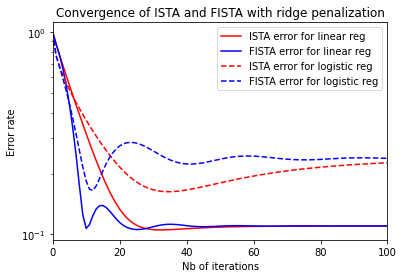

In [ ]:
# ridge penalization
plt.plot(erri_lin,'r',label = "ISTA error for linear reg")
plt.plot(errf_lin,'b',label = "FISTA error for linear reg")
plt.plot(erri_log,'r--',label = "ISTA error for logistic reg")
plt.plot(errf_log,'b--',label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Convergence of ISTA and FISTA with ridge penalization")
plt.xlim(0,100)
plt.show()

- Convergence in terms of distance to the minimum:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


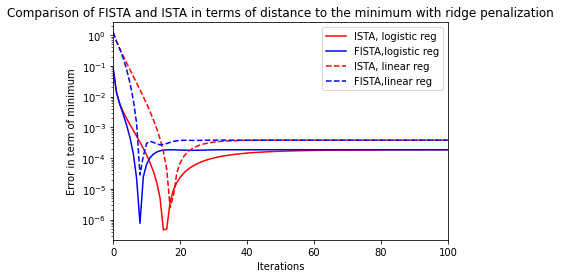

In [ ]:
# ridge penalization

true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)

plt.plot((obji_log- true_obj_log)**2,'r',label = "ISTA, logistic reg")
plt.plot((objf_log- true_obj_log)**2,'b',label = "FISTA,logistic reg")
plt.plot((obji_lin- true_obj_lin)**2,'r--',label = "ISTA, linear reg")
plt.plot((objf_lin- true_obj_lin)**2,'b--',label = "FISTA,linear reg")

ax = plt.subplot(111)
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in term of minimum")
plt.title("Comparison of FISTA and ISTA in terms of distance to the minimum with ridge penalization")
plt.xlim(0,100)
plt.show()

We now study the convergence with lasso penalization

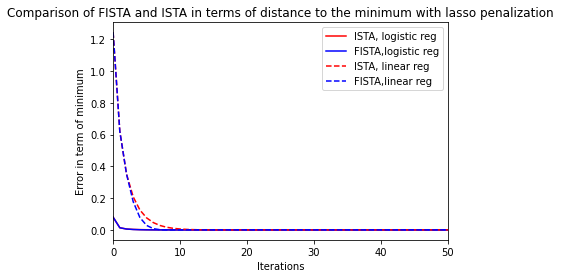

In [ ]:
# Convergence in terms of distance to the minimum  - lasso penalization

true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)

ax.set_yscale('log')
plt.plot((obji_log- true_obj_log)**2,'r',label = "ISTA, logistic reg")
plt.plot((objf_log- true_obj_log)**2,'b',label = "FISTA,logistic reg")
plt.plot((obji_lin- true_obj_lin)**2,'r--',label = "ISTA, linear reg")
plt.plot((objf_lin- true_obj_lin)**2,'b--',label = "FISTA,linear reg")

ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in term of minimum")
plt.title("Comparison of FISTA and ISTA in terms of distance to the minimum with lasso penalization")
plt.xlim(0,50)
plt.show()

We observe that the FISTA algorithm (blue line) converges faster than the ISTA algorithm (red line). 
In addition, for both algorithms and penalizations, the error is smaller when a linear regression is used.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

#### Comments:

We observe that the Lipschitz constant increases with the level of correlation. For example, the Lipschitz constant of the gradient of the linear regression is equal to 2.5 with a correlation parameter equal to 0.3 against 8.4 with a correlation parameter equal to 0.8. Since the convergence rate of the FISTA and ISTA algorithms is proportional to the Lipschitz constant, the speed of convergence of the algorithms is lower with large correlations. In this regard, the Beck Teboulle theorem states that the error is upper-bounded linearly by the Lipschitz constant.

On the graph below, we can see that as the features correlation increases, the algorithms' speed of convergence decreases.
Besides, FISTA is always better than ISTA (and more especially with high correlation).

#### Comments: 

We observe that the speed of convergence is faster when the strength of penalization is large. However, as the penalization increases, the error rate is higher. It is due to the fact that the penalization controls the tradeoff between fit and complexity: both the coefficient values and the speed of convergence are impacted by this parameter.  More precisely, as we have seen in Part 1 ("Visualization"), coefficient values are shrinked when the penalization increases ; consequently the error is larger (we underfit the data). 

Moreover, FISTA is always better than ISTA (especially when the penalization is low).